In [11]:
import os
from PIL import Image
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision
from torchvision import transforms
import matplotlib.pyplot as plt
import numpy as np
from torchvision import transforms, models

!nvidia-smi

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Mon Oct 28 13:48:02 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   55C    P0              27W /  70W |    313MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [2]:
# # from google.colab import files
# # uploaded = files.upload()

# # !unzip /path/to/your_file.zip -d /content/samples
# from google.colab import drive

# drive.mount('/content/drive')

# # Unzip the dataset into Colab’s /content directory for faster access
# !unzip '/content/drive/My Drive/Data/captcha-train.zip' -d /content/samples


Setting up a baseline model comprising ResNet-34. We will first train and test this model on a sample dataset and then perform optimisations on the same model to see if model performance is imporving.

In [18]:
## Import the dataset containing the captcha images

class CaptchaDataset(Dataset):
    def __init__(self, image_dir, transform=None):
        self.image_dir = image_dir
        self.image_files = os.listdir(image_dir)
        self.transform = transform

    def __len__(self):
        return len(self.image_files)

    def char_to_index(self, char):
      if 'a' <= char <= 'z':
        return ord(char) - ord('a')
      elif '0' <= char <= '9':
        return ord(char) - ord('0') + 26
      else:
        raise ValueError(f"Invalid character in label: {char}")


    def __getitem__(self, idx):
        # Get image path and label (from filename)
        img_name = self.image_files[idx]
        img_path = os.path.join(self.image_dir, img_name)
        label = img_name.split('.')[0]  # Filename before '.png' is the label

        # Load image
        image = Image.open(img_path).convert('RGB')

        # Apply transformations
        if self.transform:
            image = self.transform(image)

        # Convert label to a tensor of character indices
        label_tensor = torch.tensor([self.char_to_index(char) for char in label], dtype=torch.long)

        return image, label_tensor


In case you want to delete a folder

In [14]:
# import shutil

# folder_path = '/content/samples'

# shutil.rmtree(folder_path)

In [19]:

zip_file = "/content/captcha-train.zip"
!unzip -j -o $zip_file -d /content/samples

image_dir = '/content/samples'

# Check if the directory exists
if not os.path.exists(image_dir):
    raise FileNotFoundError(f"The directory '{image_dir}' does not exist.")


# Define transformations

transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize images to fit ResNet input
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Standard normalization
])


# Initialize dataset and dataloaders
dataset = CaptchaDataset(image_dir=image_dir, transform=transform)

# Split into train and test sets
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


Archive:  /content/captcha-train.zip
  inflating: /content/samples/226md.png  
  inflating: /content/samples/22d5n.png  
  inflating: /content/samples/2356g.png  
  inflating: /content/samples/23mdg.png  
  inflating: /content/samples/23n88.png  
  inflating: /content/samples/243mm.png  
  inflating: /content/samples/244e2.png  
  inflating: /content/samples/245y5.png  
  inflating: /content/samples/24f6w.png  
  inflating: /content/samples/24pew.png  
  inflating: /content/samples/25257.png  
  inflating: /content/samples/253dc.png  
  inflating: /content/samples/25egp.png  
  inflating: /content/samples/25m6p.png  
  inflating: /content/samples/25p2m.png  
  inflating: /content/samples/25w53.png  
  inflating: /content/samples/264m5.png  
  inflating: /content/samples/268g2.png  
  inflating: /content/samples/28348.png  
  inflating: /content/samples/28x47.png  
  inflating: /content/samples/2b827.png  
  inflating: /content/samples/2bg48.png  
  inflating: /content/samples/2cegf.png

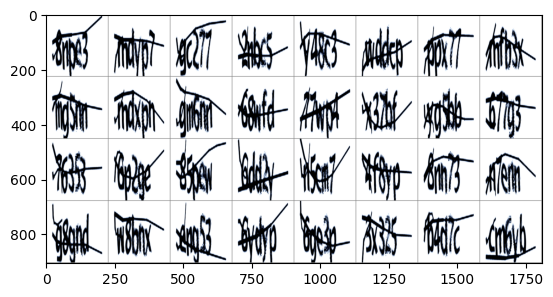

Labels: ['"\r\x0f\x04\x1d', '\x0c\x03\x18\x0f!', '\x06\x02\x1c!!', '\x1c\r\x01\x02\x1f', '\x18\x1e"\x02\x1d', '\x16\x03\x03\x02\x0f', '\x0f\x0f\x17!!', '\x0c\x05\x01\x1d\x17', '\x0c\x06\x1f\r\r', '\x0c\x03\x17\x0f\r', '\x06\x0c \r\r', ' "\x16\x05\x03', '!!\x16\x0f\x1e', '\x17\x1d!\x01\x05', '\x18\x06\x1f\x01\x01', ' !!\x06\x1d', '! \x1d\x1f\x1d', ' \x0f\x1c\x06\x04', '"\x1f\x0f\x04\x16', ' \x03\x03\x1c\x18', '\r\x1f\x02\x0c!', '\x1e\x05"\x18\x0f', '"\r\r!\x1d', '\r!\x04\r\r', '\x06"\x06\r\x03', '\x16"\x01\r\x17', '\x04\r\x06\x1f\x1d', ' \x18\x03\x18\x0f', ' \x06\x04\x1d\x0f', '\x1d\x17\x1d\x1c\x1f', '\x01\x1e\x03!\x02', '\x02\x0c \x18\x01']


In [20]:

# Helper function to display an image
def imshow(img):
    img = img / 2 + 0.5  # Unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# Display a batch of images with labels
dataiter = iter(train_loader)
images, labels = next(dataiter)

# images, labels = images[:5], labels[:5]

# Show images
imshow(torchvision.utils.make_grid(images))

# Print labels (Convert tensor labels to strings for display)
label_strs = [''.join([chr(c) for c in label]) for label in labels]
print('Labels:', label_strs)


In [21]:
unique_chars = set()
for img_name in os.listdir(image_dir):
    label = img_name.split('.')[0]
    unique_chars.update(label)

print("Unique characters in labels:", unique_chars)

Unique characters in labels: {'2', '4', 'f', 'n', 'g', '6', 'b', '8', '5', '7', 'c', 'y', 'e', 'x', 'm', 'p', 'w', 'd', '3'}


In [22]:


# Load the pretrained ResNet-34 model
model = models.resnet34(pretrained=True)

# Modify the final layer to match the number of output classes
num_classes = 36
num_characters = 5  # Assuming each CAPTCHA has 5 characters
model.fc = nn.Linear(model.fc.in_features, num_characters * num_classes)


# Move the model to GPU
model = model.to(device)


loss_function = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for images, labels in train_loader:
        # Move images and labels to GPU
        images, labels = images.to(device), labels.to(device)

        assert labels.max().item() < num_classes, f"Label values exceed num_classes ({num_classes})"


        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(images)

        outputs = outputs.view(-1, num_characters, num_classes)  # Shape: [batch_size, num_characters, num_classes]
        labels = labels.view(-1, num_characters)

        loss = sum(loss_function(outputs[:, i, :], labels[:, i]) for i in range(num_characters)) / num_characters

        # Backward pass and optimize
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}")


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch [1/10], Loss: 2.6789
Epoch [2/10], Loss: 1.6688
Epoch [3/10], Loss: 1.0439
Epoch [4/10], Loss: 0.6474
Epoch [5/10], Loss: 0.3997
Epoch [6/10], Loss: 0.2567
Epoch [7/10], Loss: 0.1668
Epoch [8/10], Loss: 0.1181
Epoch [9/10], Loss: 0.0782
Epoch [10/10], Loss: 0.0444


In [23]:
# Set the model to evaluation mode
model.eval()

correct = 0
total = 0

with torch.no_grad():
    for images, labels in test_loader:

        images, labels = images.to(device), labels.to(device)

        outputs = model(images)  # Shape: [batch_size, num_characters * num_classes]

        # Reshape outputs to match number of characters and classes per character
        outputs = outputs.view(-1, num_characters, num_classes)  # Shape: [batch_size, num_characters, num_classes]

        # Get predicted characters for each position in the CAPTCHA
        _, predicted = torch.max(outputs, 2)  # Shape: [batch_size, num_characters]

        # Compare predicted characters to true labels
        matches = (predicted == labels).all(dim=1)  # Check if all characters match for each sample
        correct += matches.sum().item()  # Count correct samples
        total += labels.size(0)  # Total number of samples

# Calculate accuracy
accuracy = 100 * correct / total
print(f"Test Accuracy: {accuracy:.2f}%")


Test Accuracy: 61.21%
